# ML - Fall 2023 - Practical - 2
## Practical Homework 2 - Naive Bayes

Student Number: 400104715

Student Name: Ali Aghayari




# Phase 0: Intro

**In this assignment, you will develop Naive Bayes models to perform text classification. The dataset contains texts and the feelings correspond to each text. Your goal is to make a model to predict the emotion associated with each given text.**

Importing necessary libraries

In [1]:
import nltk
import pandas
import sklearn
import string
import spacy
import re
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from collections import defaultdict

In [2]:
!pip install nltk

In [3]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
!wget -O dataset.csv "https://www.dropbox.com/scl/fi/vezn3809mk6br6jb2xari/ML-P2-DataSet.csv?rlkey=yweu1fhtvisqhxm78s4ofpxed&dl=1"

--2023-12-02 20:49:00--  https://www.dropbox.com/scl/fi/vezn3809mk6br6jb2xari/ML-P2-DataSet.csv?rlkey=yweu1fhtvisqhxm78s4ofpxed&dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uce178e83c55e97677b780d82ab6.dl.dropboxusercontent.com/cd/0/inline/CIrOPvdW2XaQY0Hy00DDe2lCKgIOJygcMYO1oU_hdqLCBdsysprgdQK2zBjyJ5NimuuC0bBieevhJzHIQXyFUHpP0EdaPryoNo-HHbHt4m7TI4-8qUZqCGJ8sQUaFx_Seg3FtzQfr54r7SXfEAo_QLaK/file?dl=1# [following]
--2023-12-02 20:49:01--  https://uce178e83c55e97677b780d82ab6.dl.dropboxusercontent.com/cd/0/inline/CIrOPvdW2XaQY0Hy00DDe2lCKgIOJygcMYO1oU_hdqLCBdsysprgdQK2zBjyJ5NimuuC0bBieevhJzHIQXyFUHpP0EdaPryoNo-HHbHt4m7TI4-8qUZqCGJ8sQUaFx_Seg3FtzQfr54r7SXfEAo_QLaK/file?dl=1
Resolving uce178e83c55e97677b780d82ab6.dl.dropboxusercontent.com (uce178e83c55e97677b780d82ab6.dl.dropboxusercontent.com).

# Phase 1: Explore

## Sec 1: Load and Explore the given dataset **(P1-Sec1: 10 Points)**

Load the dataset. Look at the head of dataset. How many rows are there in the dataset? **(P1-1-1: 2 points)**




In [5]:
DF = pd.read_csv("dataset.csv")
print(DF.head())
print("\n\ncount of rows : ", DF.shape[0])

                                                Text Feeling
0  i seriously hate one subject to death but now ...    fear
1                 im so full of life i feel appalled   anger
2  i sit here to write i start to dig out my feel...    fear
3  ive been really angry with r and i feel like a...     joy
4  i feel suspicious if there is no one outside l...    fear


count of rows :  5937


Handle missing values **(P1-1-2: 2 pints)**

In [6]:
print(DF.isnull().sum())
print("\n\nwe have zero null value")

Text       0
Feeling    0
dtype: int64


we have zero null value


Identify the unique feeling values and for each of them, print their count in the dataset. **(P1-1-3: 2 points)**

In [7]:
print(DF["Feeling"].value_counts())
a= DF["Feeling"].value_counts()
print("number of unique values :",DF["Feeling"].nunique())

Feeling
anger    2000
joy      2000
fear     1937
Name: count, dtype: int64
number of unique values : 3


Plot a pie chart to display the occurance frequency of each genre that you found in the prevoius part. **(P1-1-4: 2 points)**

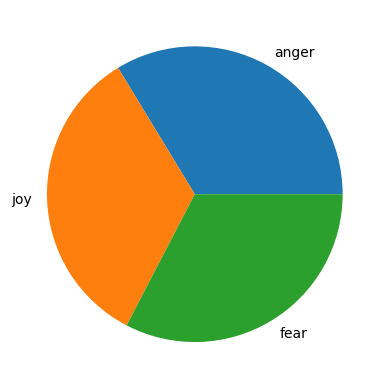

In [8]:
plt.pie(DF["Feeling"].value_counts(), labels = DF["Feeling"].value_counts().index)
plt.show()

Find the mean, max and min values of the length (in chars) of the Text Column. **(P1-1-5: 2 points)**


In [9]:
DF_text_len = DF["Text"].apply(len)
print("mean value of the length (in chars) of the Text Column : ", DF_text_len.mean())
print("max value of the length (in chars) of the Text Column : ", DF_text_len.max())
print("min value of the length (in chars) of the Text Column : ", DF_text_len.min())

mean value of the length (in chars) of the Text Column :  97.42597271349166
max value of the length (in chars) of the Text Column :  298
min value of the length (in chars) of the Text Column :  9


# Phase 2: Preprocessing

## Sec 1: Preprocess the data **(P2-Sec1: 20 Points)**

In [10]:
#from nltk.stem import PorterStemmer

class Preprocessor:
    def preprocess(self, text):
        removed_links_and_tags = self.remove_links_and_tags(text)
        tokenized = self.word_tokenize(removed_links_and_tags)
        normalized = self.normalize(tokenized)
        return normalized

    def remove_links_and_tags(self, text):
        # we will remove html tags ,email addresses and urls
        without_html = re.compile(r'<[^>]+>').sub('', text)
        doc = nlp(without_html)
        return ' '.join([x for x in doc if ((not x.like_email) and (not x.like_url))])

    def word_tokenize(self, text):
        return word_tokenize(text)

    def remove_stopwords(self, words):
        return [x for x in words if x not in stopwords.words('english')]

    def remove_punctuations(self, words):
        return [x for x in words if x.isalnum()]

    def normalize(self, words):
        # https://spotintelligence.com/2023/01/25/text-normalization-techniques-nlp/
        lowered_words = list(map(lambda x: x.lower() ,words))
        removed_punctuations = self.remove_punctuations(lowered_words)
        removed_stopwords = self.remove_stopwords(removed_punctuations)
        till_now = removed_stopwords
        # this part is optional since its library wasnt imported
        #stemmer = PorterStemmer()
        #stemmed = [stemmer.stem(word) for word in removed_stopwords]
        #till_now = stemmed
        #
        lemmatizer = WordNetLemmatizer()
        lemmatized = [lemmatizer.lemmatize(x) for x in till_now]
        # already did tokenize
        # we wont do synonym replacemnet since we dont have the dictionary
        res = lemmatized
        
        # we can remove extra things too 
        removed_symbol = re.sub(r"[\d#]", "", ' '.join(lemmatized)).split()
        removed_nonTextual = re.sub(r"(<[^>]+>)|(http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+)", "", ' '.join(removed_symbol)).split()
        res = removed_nonTextual
        
        return res 

Inspect the dataset for any empty cells or duplicate rows, and if they are present, remove the corresponding rows from the dataset. **(P2-1-1: 5 points)**

In [11]:
# we checked None values earlier so we need to check duplicate rows and remove them
print("is null count :",DF.isnull().sum())
print("count of duplicated rows : " ,DF.duplicated().sum())
print("count of duplicated Texts : " ,DF.Text.duplicated().sum())
# we wont remove these duplicated texts but i will comment the code for it 
# DF = DF.drop_duplicates(subset = "Text"))

is null count : Text       0
Feeling    0
dtype: int64
count of duplicated rows :  0
count of duplicated Texts :  3


Clean the Texts by removing the special characters and punctations. **(P2-1-2: 5 points)**

In [12]:
PP = Preprocessor()
DF.Text = DF.Text.apply(lambda x : ' '.join(PP.remove_punctuations(PP.word_tokenize(x))))
DF.head()

,Text,Feeling
0,i seriously hate one subject to death but now ...,fear
1,im so full of life i feel appalled,anger
2,i sit here to write i start to dig out my feel...,fear
3,ive been really angry with r and i feel like a...,joy
4,i feel suspicious if there is no one outside l...,fear


Remove the stop-words from the synopsis texts. Stop-words are those that have a high frequency in the language but don't have much information like 'the', 'and', 'to', etc. **(P2-1-3: 5 points)**

In [13]:
DF.Text = DF.Text.apply(lambda x : ' '.join(PP.remove_stopwords(PP.word_tokenize(x))))
DF.head()

,Text,Feeling
0,seriously hate one subject death feel reluctan...,fear
1,im full life feel appalled,anger
2,sit write start dig feelings think afraid acce...,fear
3,ive really angry r feel like idiot trusting fi...,joy
4,feel suspicious one outside like rapture happe...,fear


Tokenize the text and convert all characters to their lowercased version **(P2-1-4: 5 points)**

In [14]:
DF.Text = DF.Text.apply(lambda x : (PP.word_tokenize(x.lower())))
DF.head()

,Text,Feeling
0,"[seriously, hate, one, subject, death, feel, r...",fear
1,"[im, full, life, feel, appalled]",anger
2,"[sit, write, start, dig, feelings, think, afra...",fear
3,"[ive, really, angry, r, feel, like, idiot, tru...",joy
4,"[feel, suspicious, one, outside, like, rapture...",fear


# Phase 3: Training

## Sec 1: Preparing the training feed **(P3-Sec1: 20 Points)**

Extract the "X" and "y" numpy array from columns corresponding to text and feelings. **(P3-1-1: 5 Points)**

In [15]:
X = DF.Text.apply(lambda x : np.array(x)).to_numpy()
y = DF.Feeling.to_numpy()

# print(X[0])
# print(X)
# print("\n\n")
# print(y)
# print(y[0])

Split the dataset into two parts such that the training set (denoted as `x_train` and ‍`y_train`) contains 80% of the samples. **(P3-1-2: 5 Points)**

In [16]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# print(len(x_train))
# print(len(y_train))
# print(len(x_test))
# print(len(y_test))

Extract the text embeddings (feature vectors) for all the texts in the dataset. **(P3-1-3: 10 Points)**

For this task you can use **tf-idf** or **count vectorizer**. Search about them!

In [17]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import preprocessing # used this to solve the fit predict problem of the MultinomialNB  

# https://stackoverflow.com/questions/74345093/how-to-get-predictions-for-new-data-from-multinomialnb

X_train , X_test = [' '.join(x) for x in x_train] , [' '.join(x) for x in x_test]

le = preprocessing.LabelEncoder()
y_train_enc = le.fit_transform(y_train)

count_vec = CountVectorizer()
X_train_bow = count_vec.fit_transform(X_train)
X_train_bow = np.array(X_train_bow.todense())

## Sec 2: Naive Bayes from Scratch **(P3-Sec2: 20 Points)**

Complete this section with your code. **(P3-2: 20 points)**

In [18]:
class NaiveBayesClassifier:
    def __init__(self, alpha=1):

        '''
        Initialize these:

        Laplace smoothing parameter
        P(Y)
        P(X_i | Y)
        '''
        self.Y = None
        self.X_Y = None
        self.alpha = alpha

    def fit(self, X, y):

        '''
        Calculate class probabilities P(Y)
        Calculate word probabilities P(X_i | Y)
        '''
        n ,m = X.shape
        self.classes = np.unique(y)
        self.Y = np.zeros(len(self.classes))
        for index ,c in enumerate(self.classes):self.Y[index] = np.sum(y == c)/ float(n)
        self.X_Y = np.zeros((n,m))
        for index ,c in enumerate(self.classes):
            self.X_Y[index] = (np.sum(X[y == c] ,axis=0) + 1) / (np.sum(X[y == c]) + m)
            
    def predict(self, X):
        '''
        Calculate the log likelihood of the sample for each class

        Predict the class with the highest score
        '''
        n ,m = X.shape
        res = []
        for i in range(n):
            sample = []
            for j in range(len(self.classes)):
                c_prob = np.log(self.Y[j])
                f_prob = np.log(self.X_Y[j])
                sample.append(np.sum(X[i] @ f_prob) + c_prob)
            res.append(self.classes[np.argmax(sample)])
        return res

## Sec 3: Fit models to the training data **(P3-Sec3: 10 Points)**

Fit a Naive Bayes classifier to the data. (Use both regressors - sklearn & from scratch) **(P3-3-1: 10 points)**

In [19]:
model = MultinomialNB().fit(X_train_bow, y_train_enc)

In [20]:
my_nbc = NaiveBayesClassifier()
my_nbc.fit(X_train_bow ,y_train_enc)

# Phase 4: Evaluation

## Sec 1: Evaluate both models and compare the results (P4-Sec1: 20 points)

Predict the value of "y" for each "x" belonging to the "testing" set (use both models) **(P4-1-1: 5 points)**

In [21]:
X_test_bow = count_vec.transform(X_test)
X_test_bow = np.array(X_test_bow.todense())

y_test_enc_mnb = model.predict(X_test_bow)

In [22]:
y_test_enc_nbc = my_nbc.predict(X_test_bow)

Compute Confusion matrix and classification report for each model **(P4-1-2: 10 points)**

In [23]:
y_pred = le.inverse_transform(y_test_enc_mnb)
print("accuracy score : ", accuracy_score(y_test, y_pred) * 100 , "\n")
print("confusion matrix :")
print(confusion_matrix(y_test, y_pred) , "\n")
print("classification report :")
print(classification_report(y_test, y_pred))

accuracy score :  88.80471380471381 

confusion matrix :
[[363  22  15]
 [ 27 345   9]
 [ 30  30 347]] 

classification report :
              precision    recall  f1-score   support

       anger       0.86      0.91      0.89       400
        fear       0.87      0.91      0.89       381
         joy       0.94      0.85      0.89       407

    accuracy                           0.89      1188
   macro avg       0.89      0.89      0.89      1188
weighted avg       0.89      0.89      0.89      1188



In [24]:
y_pred = le.inverse_transform(y_test_enc_nbc)
print("accuracy score : ", accuracy_score(y_test, y_pred) * 100 , "\n")
print("confusion matrix :")
print(confusion_matrix(y_test, y_pred) , "\n")
print("classification report :")
print(classification_report(y_test, y_pred))

accuracy score :  88.80471380471381 

confusion matrix :
[[363  22  15]
 [ 27 345   9]
 [ 30  30 347]] 

classification report :
              precision    recall  f1-score   support

       anger       0.86      0.91      0.89       400
        fear       0.87      0.91      0.89       381
         joy       0.94      0.85      0.89       407

    accuracy                           0.89      1188
   macro avg       0.89      0.89      0.89      1188
weighted avg       0.89      0.89      0.89      1188



Explain the results of the previous section (what is f1-score? - what is the recall? - what is precision?), also compare the model's performance **(P4-1-3: 5 points)**

***f1 - score*** <br/>
harmonic mean of precision and recall<br/>
we will discuss precision and recall later<br/>
***recall*** <br/>
it answers the question " when it is actually the positive result ,how often does it predict correctly? "<br/>
in this case we are trying to limit the False negatives<br/>
it is also known as "sensivity" or "true positive rate" <br/>
***precision*** <br/>
it answers the question " when it predicts the positive result ,how often is it correct? "<br/>
in this case we are trying to limit the False positives<br/>

our model performance are the same , probably because we are using the same algorithm! 

Model Performance Intuition Part: Now, you can test whether your model has a good prediction for a random text.

In [25]:
# example = datatransform(["Look! behind that tree there is a secret object, I am so scared"])
# model.predict(example)

# Phase 5: Neural Net (Bonus)

Make a list of words available in the dataset

In [26]:
unique = set()
for x in X : 
    unique.update(set(x))

Retrieve the Word2Vec embeddings for each word

In [27]:
!pip install gensim
from gensim.models import Word2Vec

X = [list(x) for x in X]

word_model = Word2Vec(X, vector_size=100, window=5, min_count=1, workers=4)

Train a neural network consisting of LSTM and Fully-Connected layers to perform text classification **(P5-1: 8 points)**

Note: To get the points, Your neural net's performance should be at least as good as the Naive Bayes classifier. The exact architecture of the neural net is up to you. You can use Pytorch or Tensorflow to train it.

Evaluate the neural net on the training and testing data from the section *3-1-2*. **(P5-2: 2 points)**

# Phase 6 (Optional): Submit your predictions to our Kaggle competition

Competition Link: https://www.kaggle.com/t/97bcc22bb3dc4a1dbdb78b736ebe3744

In [28]:
'''
TRAIN = pd.read_csv("/kaggle/input/contest/train.csv")
TEST = pd.read_csv("/kaggle/input/contest/test.csv")

PP = Preprocessor()
TRAIN.Text = TRAIN.Text.apply(lambda x : ' '.join(PP.remove_punctuations(PP.word_tokenize(x))))
TRAIN.Text = TRAIN.Text.apply(lambda x : ' '.join(PP.remove_stopwords(PP.word_tokenize(x))))
TRAIN.Text = TRAIN.Text.apply(lambda x : (PP.word_tokenize(x.lower())))

TEST.Text = TEST.Text.apply(lambda x : ' '.join(PP.remove_punctuations(PP.word_tokenize(x))))
TEST.Text = TEST.Text.apply(lambda x : ' '.join(PP.remove_stopwords(PP.word_tokenize(x))))
TEST.Text = TEST.Text.apply(lambda x : (PP.word_tokenize(x.lower())))

x_train = TRAIN.Text.apply(lambda x : np.array(x)).to_numpy()
y_train = TRAIN.target.to_numpy()

x_test = TEST.Text.apply(lambda x : np.array(x)).to_numpy()

X_train , X_test = [' '.join(x) for x in x_train] , [' '.join(x) for x in x_test]

le = preprocessing.LabelEncoder()
y_train_enc = le.fit_transform(y_train)

count_vec = CountVectorizer()
X_train_bow = count_vec.fit_transform(X_train)
X_train_bow = np.array(X_train_bow.todense())

my_nbc = NaiveBayesClassifier()
my_nbc.fit(X_train_bow ,y_train_enc)

X_test_bow = count_vec.transform(X_test)
X_test_bow = np.array(X_test_bow.todense())
y_test_enc_nbc = my_nbc.predict(X_test_bow)

y_pred = le.inverse_transform(y_test_enc_nbc)

my_submission = pd.DataFrame({'ID': TEST.ID, 'target': y_pred})
my_submission.to_csv('practical2_400104715.csv', index=False)
'''

'\nTRAIN = pd.read_csv("/kaggle/input/contest/train.csv")\nTEST = pd.read_csv("/kaggle/input/contest/test.csv")\n\nPP = Preprocessor()\nTRAIN.Text = TRAIN.Text.apply(lambda x : \' \'.join(PP.remove_punctuations(PP.word_tokenize(x))))\nTRAIN.Text = TRAIN.Text.apply(lambda x : \' \'.join(PP.remove_stopwords(PP.word_tokenize(x))))\nTRAIN.Text = TRAIN.Text.apply(lambda x : (PP.word_tokenize(x.lower())))\n\nTEST.Text = TEST.Text.apply(lambda x : \' \'.join(PP.remove_punctuations(PP.word_tokenize(x))))\nTEST.Text = TEST.Text.apply(lambda x : \' \'.join(PP.remove_stopwords(PP.word_tokenize(x))))\nTEST.Text = TEST.Text.apply(lambda x : (PP.word_tokenize(x.lower())))\n\nx_train = TRAIN.Text.apply(lambda x : np.array(x)).to_numpy()\ny_train = TRAIN.target.to_numpy()\n\nx_test = TEST.Text.apply(lambda x : np.array(x)).to_numpy()\n\nX_train , X_test = [\' \'.join(x) for x in x_train] , [\' \'.join(x) for x in x_test]\n\nle = preprocessing.LabelEncoder()\ny_train_enc = le.fit_transform(y_train)\n\n